In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(6144, 28)
(6144, 2)


In [6]:
X_motion_CoM_continuous[0]

array([0.10000000149, 0.0, 0.0, 0.0436246310365, -0.0623315640547,
       0.0287474770733, 0.00923197799037, 0.00911098074187,
       0.0170479861481, 0.224820686714, 0.183767871704, -0.430754512842,
       0.242106336986, -0.169746484127, -0.431367276325, -0.237076912098,
       0.166767282807, -0.429774324185, -0.255938460943, -0.144975919339,
       -0.430475608633, True, False, False, True, 0.10000000149, 0.0, 0.0],
      dtype=object)

In [7]:
Y_motion_CoM_continuous[0]

array([0.007738653999979306, 0.010271654219999427], dtype=object)

# Multivariate Linear Regression (CoM Prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM[:, 22] == 1)[0]
X_motion_CoM_FR_RL = X_motion_CoM[idx_fr_rl_swinging]
Y_motion_CoM_FR_RL = Y_motion_CoM[idx_fr_rl_swinging]
print(X_motion_CoM_FR_RL.shape)
print(Y_motion_CoM_FR_RL.shape)

(3058, 28)
(3058, 2)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_FR_RL[0, :]

array([0.0, 0.0, 0.0, 0.00414320083234, 0.0423456998526, 0.0302417324125,
       0.0342928695961, 0.0109268918862, -0.0171816316776, 0.233724213209,
       0.173853947388, -0.43106930076, 0.233885598495, -0.181638280555,
       -0.431398712053, -0.248552996902, 0.147235501845, -0.430214819006,
       -0.249748787792, -0.162153317943, -0.428328971712, False, True,
       True, False, 0.10000000149, 0.0, 0.0], dtype=object)

In [11]:
Y_motion_CoM_FR_RL[0, :]

array([0.008177117900004305, -0.015584770040000029], dtype=object)

### Linear Regression

In [12]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # motion command
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20]))
               
# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9796303622228526
RMSE:  0.0027741422798221297
The lowest error is:  5.8668345178647385e-06
The highest error is:  0.019288225143355292
The avg. error is:  0.0016378609150809109


In [13]:
model_fr_com_x.coef_

array([[ 4.63028816e-03,  1.80411242e-16, -1.60461922e-16,
         1.19860834e-01,  4.16333634e-17,  1.52655666e-16,
         4.37501754e-02,  9.30692625e-01,  1.16193353e-01,
         7.53660558e-02,  1.89459571e-01, -1.99287383e-02,
         6.64589061e-02, -8.97049564e-02]])

In [14]:
model_fr_com_x.intercept_

array([-0.13682552])

Text(0, 0.5, 'Predictions')

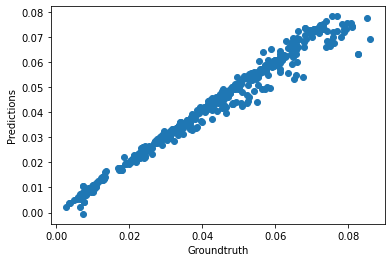

In [15]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [16]:
#%store model_fr_com_x

In [17]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [18]:
# Save model
#joblib.dump(model_fr_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [19]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # motion command
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20]))

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9184492455610436
RMSE:  0.0016018295374058272
The lowest error is:  4.160136026609695e-06
The highest error is:  0.007719988703296432
The avg. error is:  0.0011522389832191793


In [20]:
model_fr_com_y.coef_

array([[-5.40070997e-03, -4.51028104e-17, -1.38777878e-17,
        -3.79320115e-02, -1.11022302e-16,  5.55111512e-17,
         1.37126576e-01,  5.10276036e-02, -1.75545696e-01,
         3.44530615e-01, -3.46190727e-02,  1.56475485e-01,
         1.48954386e-01,  7.84449105e-02]])

In [21]:
model_fr_com_y.intercept_

array([0.06921374])

Text(0, 0.5, 'Predictions')

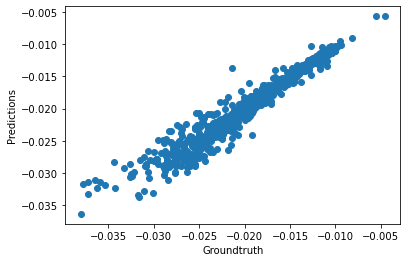

In [22]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [47]:
#%store model_fr_com_y

In [48]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [29]:
# Save model
#joblib.dump(model_fr_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_y.sav")